In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
#load the augmented image from directory and generate datasetc
batch_size= 32
img_height= 224
img_width= 224

train_datagen= tf.keras.preprocessing.image.ImageDataGenerator(
   rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
)

test_datagen= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(
        './dataset/training', 
        target_size= (img_width, img_height),  
        batch_size= batch_size,
        class_mode= 'categorical')  #use categorical_crossentropy loss for multi-class


validation_generator= test_datagen.flow_from_directory(
        './dataset/validation',
        target_size= (img_width, img_height),
        batch_size= batch_size,
        class_mode='categorical')

Found 508 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


Tensor shape with batch 32:  (32, 224, 224, 3)


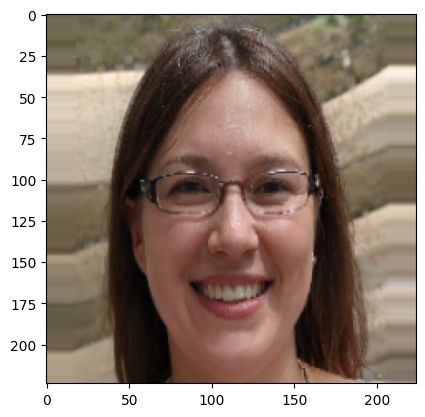

In [4]:
#Tensor shape of images generated by ImageGenerator
print("Tensor shape with batch 32: ", train_generator[0][0].shape)
#print(train_generator.shape)
image= train_generator[0][0][0]
plt.imshow(image)

In [5]:
labels= (train_generator.class_indices)
labels= dict((v,k) for k,v in labels.items())
print(labels)

{0: 'NoTic', 1: 'Tic'}


In [6]:
numclass= len(labels)
print(numclass)

2


In [7]:
numclass= len(labels)
model= models.Sequential()
model.add(tf.keras.Input(shape=(img_height, img_width, 3)))
    
#Second Conv layer
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))
    
#Third, fourth, fifth convolution layer
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu')) 
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(numclass, activation='sigmoid'))
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 512)     1180160   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 512)     2359808   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 105, 256)     1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 256)       0

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history= model.fit(train_generator, validation_data=validation_generator, epochs= 100, verbose=1)

Epoch 1/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6945 - accuracy: 0.4688

In [ ]:
model.save("TICScdataset.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#serialize model to json
json_model= model.to_json()

#Save the model architecture to a JSON file
with open('TICScdataset_model.json', 'w') as json_file:
    json_file.write(json_model)

#Save the model weights
model.save_weights('TICScdataset_weights.h5')

In [ ]:
#Final evaluation of the model
scores= model.evaluate(validation_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

15/15 [==============================] - 22s 1s/step - loss: 0.5246 - accuracy: 0.9622
Accuracy: 96.22%


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc= history.history['accuracy']
    val_acc= history.history['val_accuracy']
    loss= history.history['loss']
    val_loss= history.history['val_loss']
    x= range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

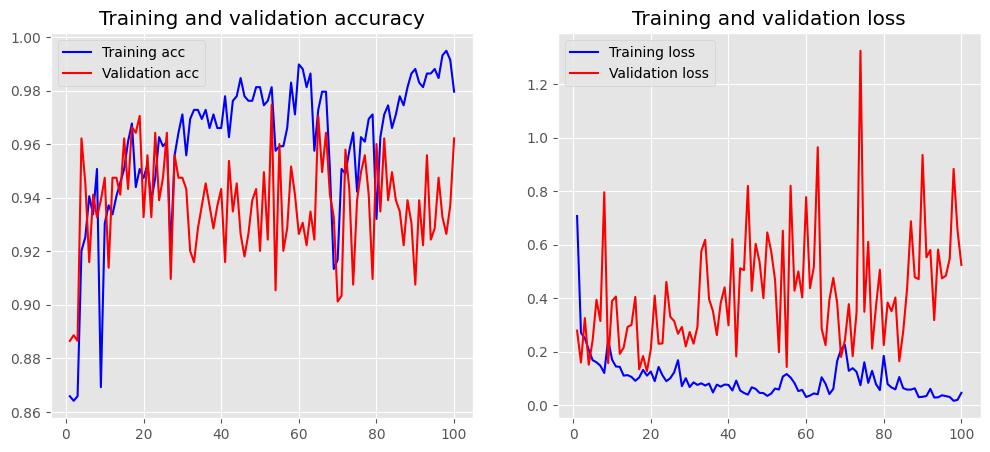

In [ ]:
plot_history(history)

In [10]:
#Load the previously saved model eg. flowers_model.h5
model= models.Sequential()

model= models.load_model("./TICS2.h5")

#The label that classifing
labels= {0: 'NoTic', 1: 'Tic'}
testimage_path= "./dataset/testing/Tic2.jpg"

img= tf.keras.preprocessing.image.load_img(testimage_path, target_size=(80, 80))

img_array= tf.keras.preprocessing.image.img_to_array(img)
img_array= tf.expand_dims(img_array, 0)
print(img_array.shape)

#CLassify the input image data
predictions= model.predict(img_array)

#Convert into final result using softmax
score= tf.nn.softmax(predictions)

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(labels[np.argmax(score)], 100 * np.max(score)))

(1, 80, 80, 3)
This image most likely belongs to NoTic with a 73.11 percent confidence.


In [6]:
#Load the previously saved model eg. flowers_model.h5
model= models.Sequential()

model= models.load_model("./model/TICs.h5")

#The label that classifing
labels= {0: 'NoTic', 1: 'Tic'}
testimage_path= "./dataset/testing/Tic3.png"

img= tf.keras.preprocessing.image.load_img(testimage_path, target_size=(80, 80))

img_array= tf.keras.preprocessing.image.img_to_array(img)
img_array= tf.expand_dims(img_array, 0)
print(img_array.shape)

#CLassify the input image data
predictions= model.predict(img_array)

#Convert into final result using softmax
score= tf.nn.softmax(predictions)

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(labels[np.argmax(score)], 100 * np.max(score)))

(1, 80, 80, 3)
This image most likely belongs to Tic with a 73.11 percent confidence.
